# Social Network Analysis 
Written by Jin Cheong & Luke Chang




In [23]:
import pickle, os
import pymongo as pm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pickle
import json
import os
import networkx as nx
%matplotlib inline

In [85]:
dbName = '13May16' #replace this with most recent db created from running pickleFNL.py
subPath = os.path.join('../Data/',dbName,'subjects.p')
userPath = os.path.join('../Data/',dbName,'users.p')
Subjects = pickle.load(open('../Data/13May16/subjects.p','rb'))
Users = pickle.load(open('../Data/13May16/users.p','rb'))

#Test user accounts to ignore
testUsers = ['ejolly@test.com','test@test.com','aratidoo@gmail.com','anna.t.prescott.gr@dartmouth.edu']
userIds = {}
for user in Users:
    email = user['emails'][0]['address']
    if email not in testUsers:
        meteorID = user['_id']
        userIds[email] = meteorID

#Filter out test users from actual data
for i, sub in enumerate(Subjects):
    if sub['_id'] not in userIds.values():
        Subjects.pop(i)
Subjects = pd.DataFrame(Subjects)

In [25]:
#Define some helper functions, one to get the data for a particular question type and the other to plot, and then one to call both
def getDim(dim,subs = Subjects):
    out = []
    for i,s in subs.iterrows():
        eData = pd.DataFrame(s['episodeData'])
        dimData = pd.concat([pd.Series(eData.ix[dim,i]) for i in xrange(eData.shape[1])],axis=1)
        out.append(dimData)
    return out 

def plotDim(data,key):    
    fig,axes = plt.subplots(len(data),1,figsize = (20,20));
    #Find out who's watched farthest for adjusting the plots
    maxEp = max([elem.shape[1] for elem in data])

    for i, sub in enumerate(data):
        ax = sub.T.plot(ax=axes[i],legend=False)
        ax.set_xticks(xrange(maxEp));
        ax.set_xticklabels(['ep'+ str(i) for i in xrange(1,maxEp+1)],fontsize=14);
    #Axes for just 1
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
              ncol=5, fontsize= 14)
    plt.suptitle('Dimension: ' + key, fontsize=25);

def plotEpisodeData(dimension):
    data = getDim(dimension)
    plotDim(data,dimension)

In [26]:
#Here are the different questions we asked
keys = pd.DataFrame(Subjects.ix[0,'episodeData']).index.values
print [str(key) for key in keys]

['annoy', 'attractive', 'be', 'care', 'friends', 'like', 'likePair', 'listenPair', 'relate', 'remind', 'trustPair']


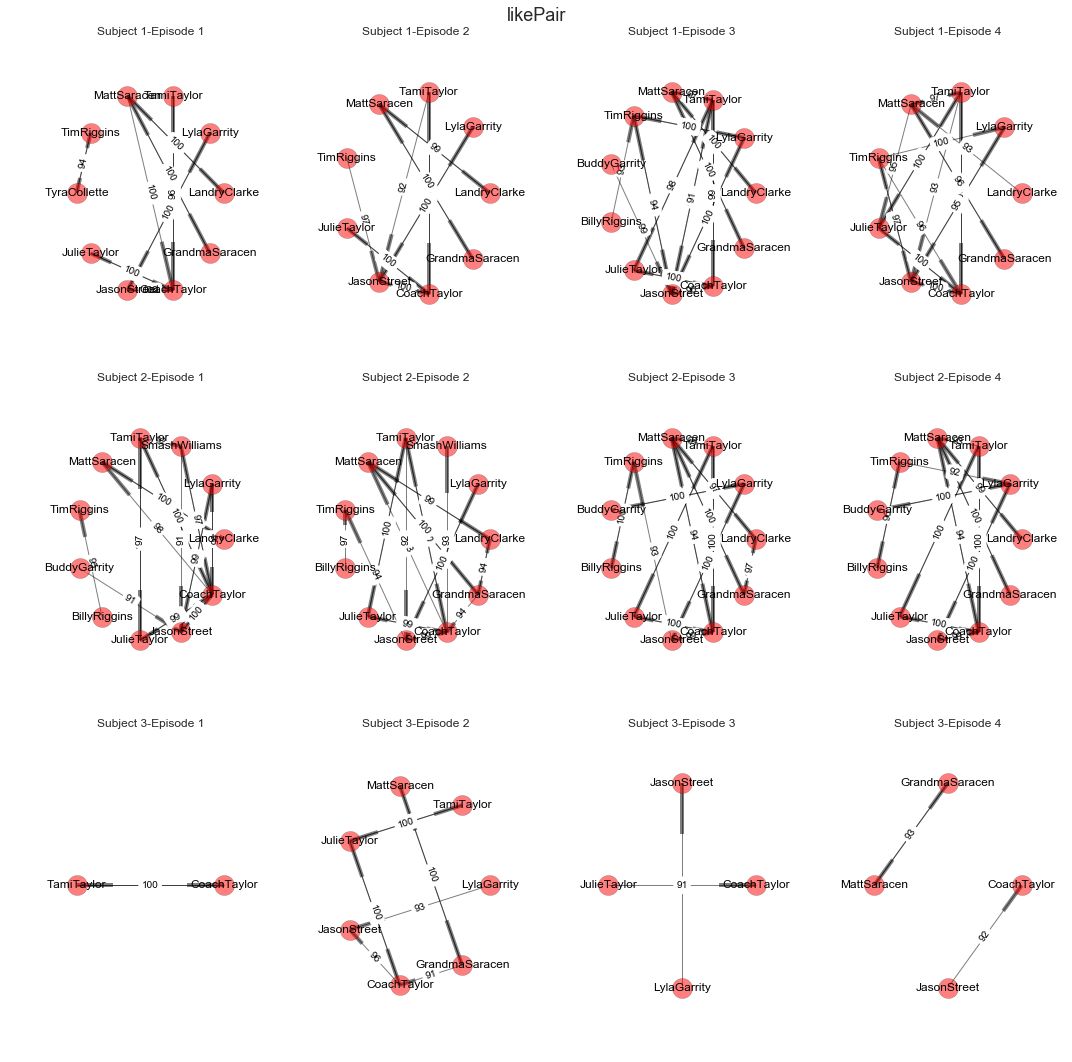

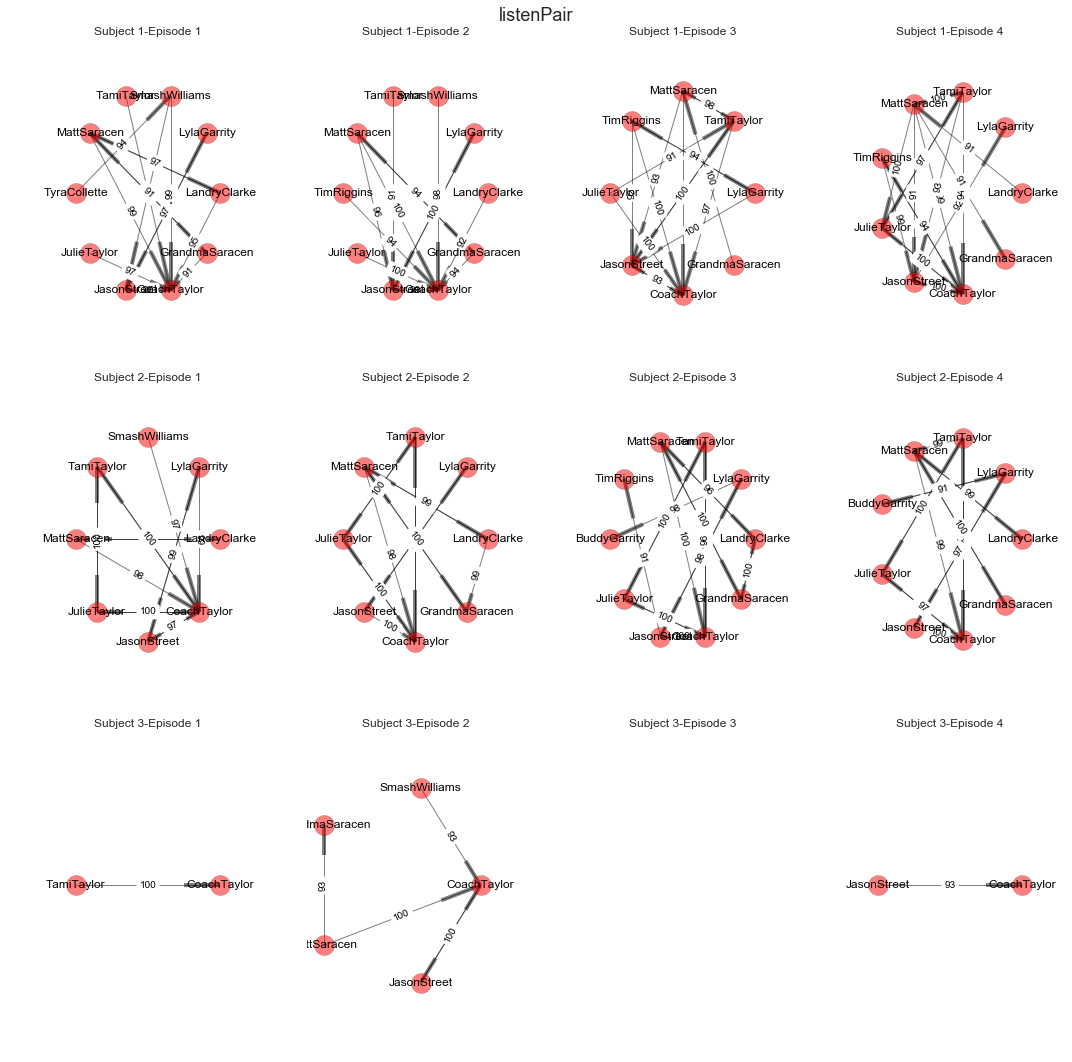

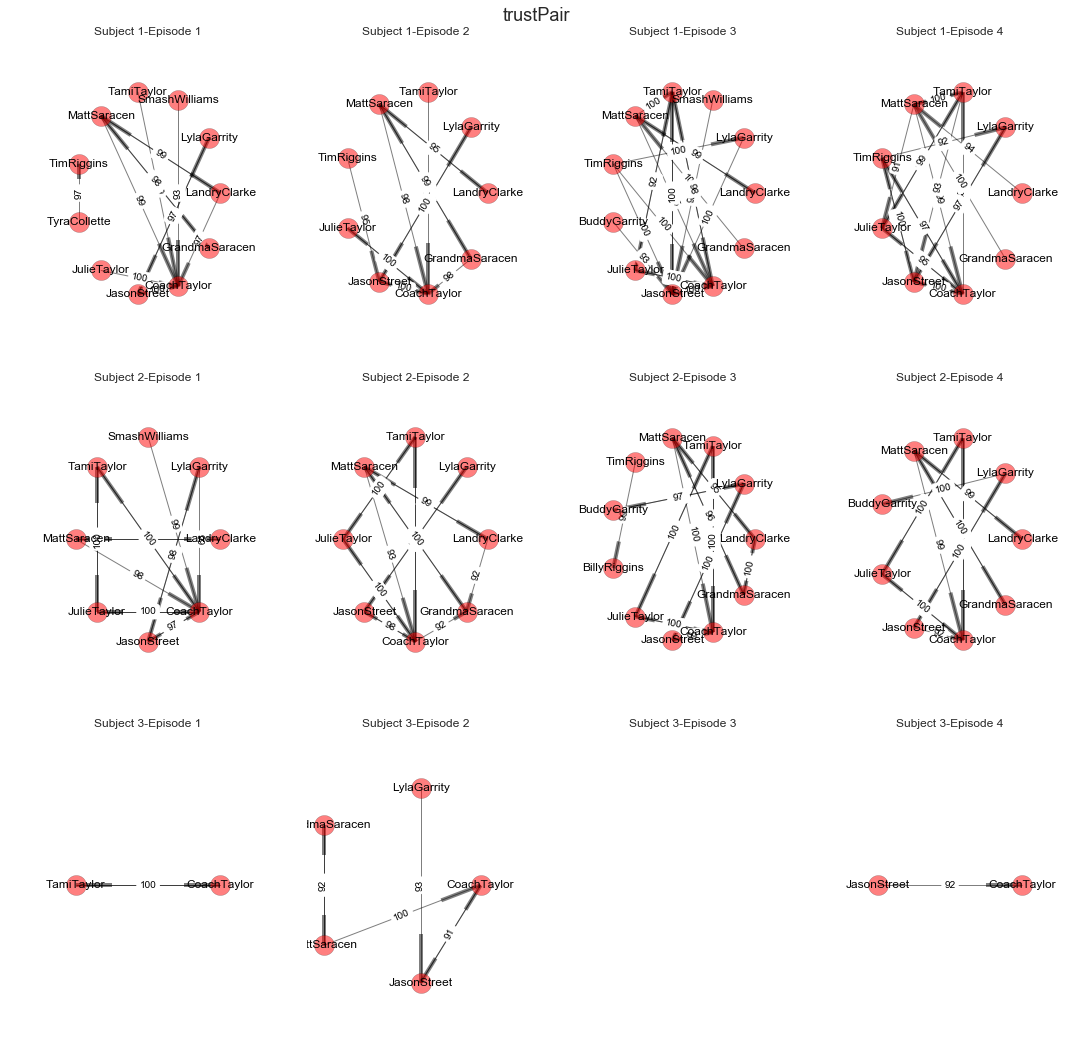

In [270]:
# 
keys = ['likePair','listenPair','trustPair']
threshold = 90;
for key in keys:
    df = getDim(key)
    subjects = [0,1,2]
    plt.figure(figsize=(15,15))
    loc =0
    for subj in subjects:
        data = df[subj]
        episodes =[0,1,2,3]
        for ep in episodes:
            edges =[]
            test = data[[ep]]
            test.reset_index()
            for i in range(156):
                x = test.index.values[i].split('_')
                x[0] = str(x[0])
                x[1] = str(x[1])
                x.append(test[[ep]][ep][i])
                if test[[ep]][ep][i] > threshold:
                    edges.append(tuple(x))

            DG=nx.DiGraph()
            DG.add_weighted_edges_from(edges)

            edge_labels=dict([((u,v,),d['weight'])
                             for u,v,d in DG.edges(data=True)])

#             pos = nx.spring_layout(DG)
            # pos = nx.fruchterman_reingold_layout(DG,dim=2)
            pos = nx.circular_layout(DG)
            loc = len(episodes)*(subj)+ep+1
            ax = plt.subplot(len(subjects),len(episodes),loc)
            nx.draw_networkx_edge_labels(DG,pos,edge_labels=edge_labels,ax =ax,alpha=.5)
            nx.draw(DG,pos,node_size=400,with_labels=True,ax=ax,alpha=.5)
            plt.title('Subject '+str(subj+1)+'-Episode '+str(ep+1))
    plt.suptitle(key,fontdict={'fontsize':18})
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(key+'_circ_threshold_' + str(threshold) +'.png',dpi=300)
    plt.show()

# What should we look for in a network ? 

Great [Wikipedia article](https://en.wikipedia.org/wiki/Centrality) and [example](http://www.orgnet.com/sna.html)

From Wikipedia: In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, and super-spreaders of disease. Each one of the figures  represent a different kind of centrality. 

<img src="Figures/centrality.png",width=300>

## Degree Centrality

What are the Degree Centrality of the Characters based on their likings

In [268]:
# Get a piece of data to look at but use a undirected graph
threshold = 85;
key = 'likePair'
df = getDim(key)
subjects = [0,1,2]
loc =0
subj = 1
ep = 3
data = df[subj]
edges =[]
test = data[[ep]]
test.reset_index()
for i in range(156):
    x = test.index.values[i].split('_')
    x[0] = str(x[0])
    x[1] = str(x[1])
    x.append(test[[ep]][ep][i])
    if test[[ep]][ep][i] > threshold:
        edges.append(tuple(x))

G=nx.Graph()
G.add_weighted_edges_from(edges)

If we just look at degree centrality, Matt Saracen is equivalent to Coach Taylor. 

In [324]:
d = nx.degree_centrality(G)
print "Degree Centrality"
for k, v in d.iteritems():
    print k.ljust(15), str(v).ljust(30)

Degree Centrality
LandryClarke    0.2                           
LylaGarrity     0.3                           
TamiTaylor      0.3                           
MattSaracen     0.4                           
TimRiggins      0.3                           
BuddyGarrity    0.1                           
BillyRiggins    0.1                           
JulieTaylor     0.2                           
JasonStreet     0.3                           
CoachTaylor     0.4                           
GrandmaSaracen  0.2                           


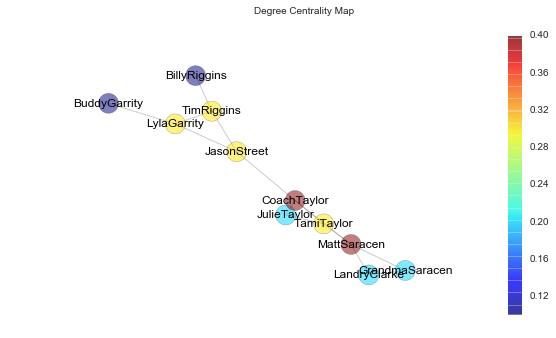

In [316]:
val_map = nx.degree_centrality(G)
values = [val_map.get(node, 0.25) for node in G.nodes()]
plt.figure(figsize=(10,5))
np.random.seed(4)
pos = nx.fruchterman_reingold_layout(G,dim=2)
ec = nx.draw_networkx_edges(G,pos,alpha=.2)
nc = nx.draw_networkx_nodes(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
nx.draw_networkx_labels(G,pos,font_size=12)
# nx.draw(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
plt.colorbar(nc)
plt.axis('off')
plt.suptitle('Degree Centrality Map')
plt.show()

# Betweenness Centrality
Think of Between Centrality as a bottleneck or a broker of two separate networks. 

Coach Taylor is much more central in betweenness compared to Matt Saracen.

In [325]:
print "Betweenness Centrality"
for k, v in nx.betweenness_centrality(G).iteritems():
    print k.ljust(15), str(v).ljust(30)

Betweenness Centrality
LandryClarke    0.0                           
LylaGarrity     0.2                           
TamiTaylor      0.0333333333333               
MattSaracen     0.355555555556                
TimRiggins      0.2                           
BuddyGarrity    0.0                           
BillyRiggins    0.0                           
JulieTaylor     0.0                           
JasonStreet     0.533333333333                
CoachTaylor     0.588888888889                
GrandmaSaracen  0.0                           


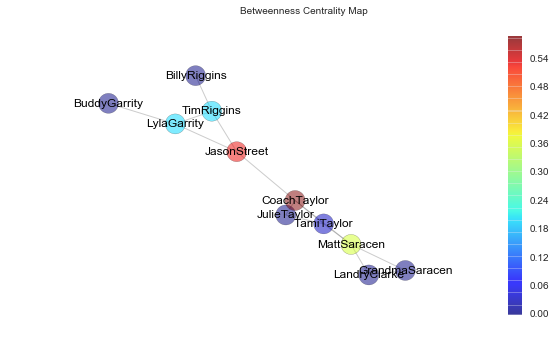

In [315]:
val_map = nx.betweenness_centrality(G)
values = [val_map.get(node, 0.25) for node in G.nodes()]
plt.figure(figsize=(10,5))
np.random.seed(4)
pos = nx.fruchterman_reingold_layout(G,dim=2)
ec = nx.draw_networkx_edges(G,pos,alpha=.2)
nc = nx.draw_networkx_nodes(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
nx.draw_networkx_labels(G,pos,font_size=12)
# nx.draw(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
plt.colorbar(nc)
plt.axis('off')
plt.suptitle('Betweenness Centrality Map')
plt.show()

# Closeness Centrality
Who can get to other people the fastest

In [327]:
print "Closeness Centrality"
for k, v in nx.closeness_centrality(G).iteritems():
    print k.ljust(15), str(v).ljust(30)

Closeness Centrality
LandryClarke    0.333333333333                
LylaGarrity     0.416666666667                
TamiTaylor      0.434782608696                
MattSaracen     0.454545454545                
TimRiggins      0.416666666667                
BuddyGarrity    0.30303030303                 
BillyRiggins    0.30303030303                 
JulieTaylor     0.384615384615                
JasonStreet     0.526315789474                
CoachTaylor     0.555555555556                
GrandmaSaracen  0.333333333333                


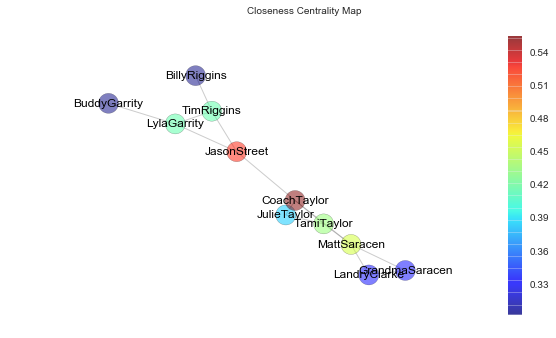

In [329]:
val_map = nx.closeness_centrality(G)
values = [val_map.get(node, 0.25) for node in G.nodes()]
plt.figure(figsize=(10,5))
np.random.seed(4)
pos = nx.fruchterman_reingold_layout(G,dim=2)
ec = nx.draw_networkx_edges(G,pos,alpha=.2)
nc = nx.draw_networkx_nodes(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
nx.draw_networkx_labels(G,pos,font_size=12)
# nx.draw(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
plt.colorbar(nc)
plt.axis('off')
plt.suptitle('Closeness Centrality Map')
plt.show()

# Eigenvector Centrality
Total influence in the network

In [328]:
print "Eigenvector Centrality"
for k, v in nx.eigenvector_centrality(G).iteritems():
    print k.ljust(15), str(v).ljust(30)

Eigenvector Centrality
BuddyGarrity    0.051933456401                
BillyRiggins    0.0506513343235               
LandryClarke    0.226737557427                
JulieTaylor     0.327184836156                
LylaGarrity     0.159419282494                
CoachTaylor     0.506141280513                
JasonStreet     0.271123995875                
TamiTaylor      0.437963227884                
GrandmaSaracen  0.227973246046                
MattSaracen     0.462832453622                
TimRiggins      0.152244299899                


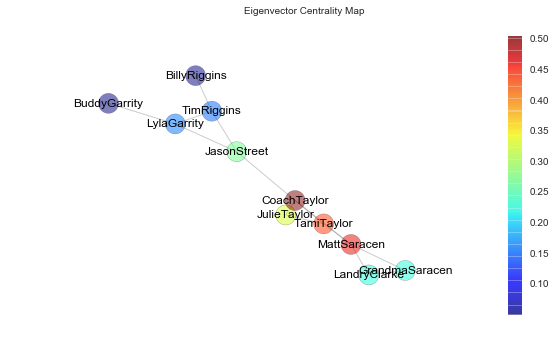

In [330]:
val_map = nx.eigenvector_centrality(G)
values = [val_map.get(node, 0.25) for node in G.nodes()]
plt.figure(figsize=(10,5))
np.random.seed(4)
pos = nx.fruchterman_reingold_layout(G,dim=2)
ec = nx.draw_networkx_edges(G,pos,alpha=.2)
nc = nx.draw_networkx_nodes(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
nx.draw_networkx_labels(G,pos,font_size=12)
# nx.draw(G,pos,node_size=400,with_labels=True,alpha=.5,cmap=plt.get_cmap('jet'),node_color=values)
plt.colorbar(nc)
plt.axis('off')
plt.suptitle('Eigenvector Centrality Map')
plt.show()